# Predictions

## Summary:
From the results of the best models in the previous step (KNN with transformation of the variables and Random Forest), it is time to plot the predictions into global-scale maps

### Load libraries
`raster` for spatial data manipulation as well as predict function  
`tidyverse` for data manipulation  
`randomForest` to perform random forest predictions with raster::predict()

In [17]:
library(raster)
library(tidyverse)
library(randomForest)
source("D:/TFM Data Science/config.R")


Warning message:
"package 'randomForest' was built under R version 3.5.3"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




### Create a 'latitude' map
This will be used to include the variable latitude ('y') as a map layer into the model.  
The process consists of extracting the latitude values from each cell of an example map and inserting them into the cell values of a 'y map' (that is just a duplicate of the example).

In [3]:
list_bioclims <- list.files(file.path(path_bioclim), full.names = T)
raster_example <- raster(list_bioclims[1])

y_raster <- raster_example

y_data <- yFromCell(raster_example,cell=1:ncell(raster_example))
y_raster[1:ncell(raster_example)] <- abs(y_data)

background_map <- reclassify(raster_example, matrix(c(-100, 100, 0), ncol=3))
y_raster_clean <- y_raster+background_map
rm(background_map, raster_example)

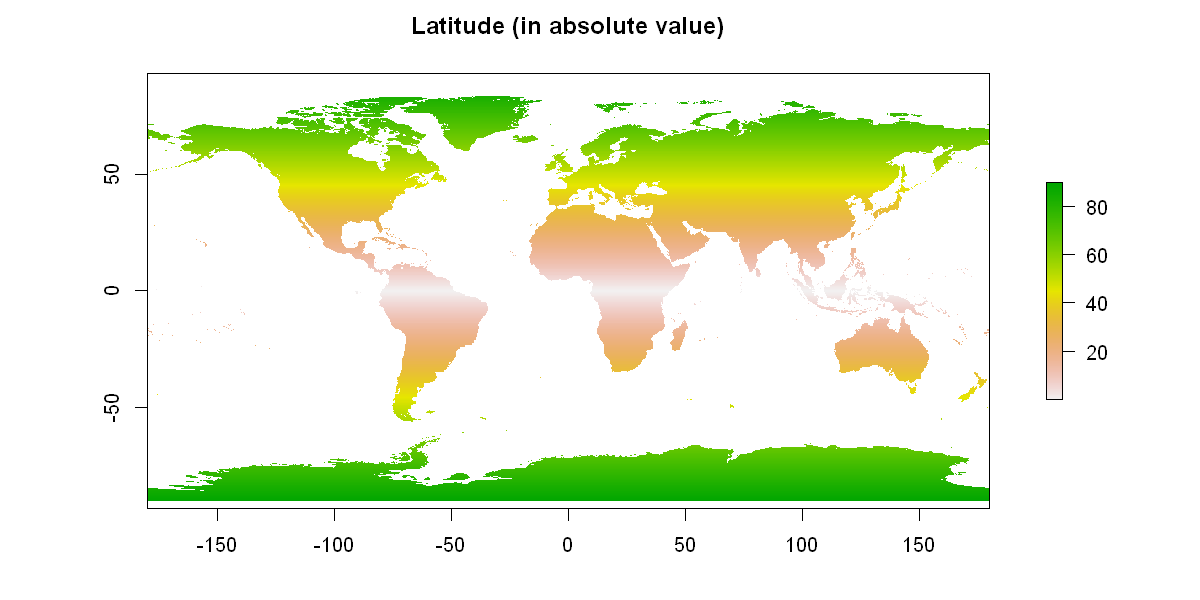

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot(y_raster_clean, main="Latitude (in absolute value)")


### Load bioclim layers

Load the bioclim layers into a brick object

In [5]:
beginCluster()
all_bio <- brick(stack(list_bioclims))
endCluster()


Loading required namespace: parallel

12 cores detected, using 11



Add the latitude layer into the brick

In [6]:
all_bio <- addLayer(y_raster_clean, all_bio)

Change the names of the layers to match the names of the variables in the model

In [7]:
names(all_bio) <- c("y", sub("wc2.1_5m_", "", names(all_bio)[2:20]))
names(all_bio)

[1] "y"      "bio_1"  "bio_10" "bio_11" "bio_12" "bio_13" "bio_14" "bio_15"
 [9] "bio_16" "bio_17" "bio_18" "bio_19" "bio_2"  "bio_3"  "bio_4"  "bio_5" 
[17] "bio_6"  "bio_7"  "bio_8"  "bio_9"

### Load models

In [12]:
models_list <- list.files(path_models, pattern=".rds", full.names = T)

reg_rf_tune <- readRDS(grep("RF_train_tune_35k", models_list, value = T))
reg_KNN_norm <-readRDS(grep("KNN_norm_train_35k", models_list, value = T))

### Load NPP map
Clean version prepared in the first step (Data preparation)

In [14]:
clean_npp <- raster(file.path(path_NPP, "NPP_map_clean.tif"))


Bonus: create a map of surface with NPP data to filter predictions

In [15]:
npp_area <- reclassify(clean_npp, matrix(c(0, 3000, 0), ncol=3))

### Random Forest prediction

In [18]:
beginCluster()
RF_prediction <- raster::predict(all_bio, reg_rf_tune)
endCluster()
RF_prediction <- RF_prediction + npp_area 



12 cores detected, using 11

Warning message in RF_prediction + npp_area:
"Raster objects have different extents. Result for their intersection is returned"


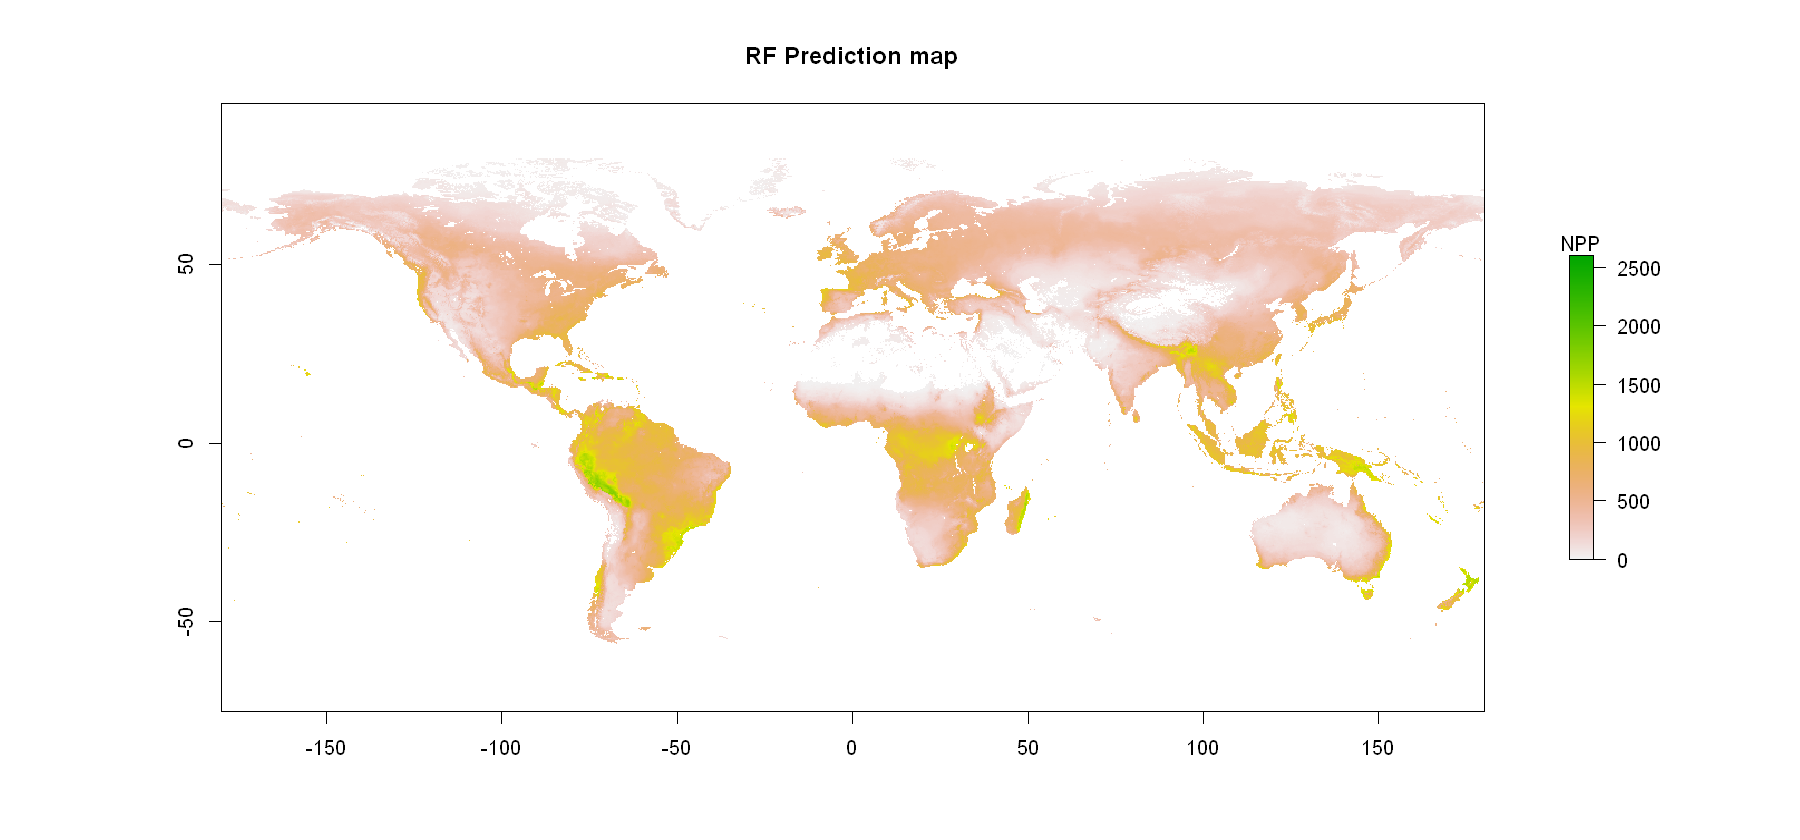

In [19]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot(RF_prediction, main="RF Prediction map",legend.args = list(text = 'NPP'), zlim=c(0,2600))

Compare predictions

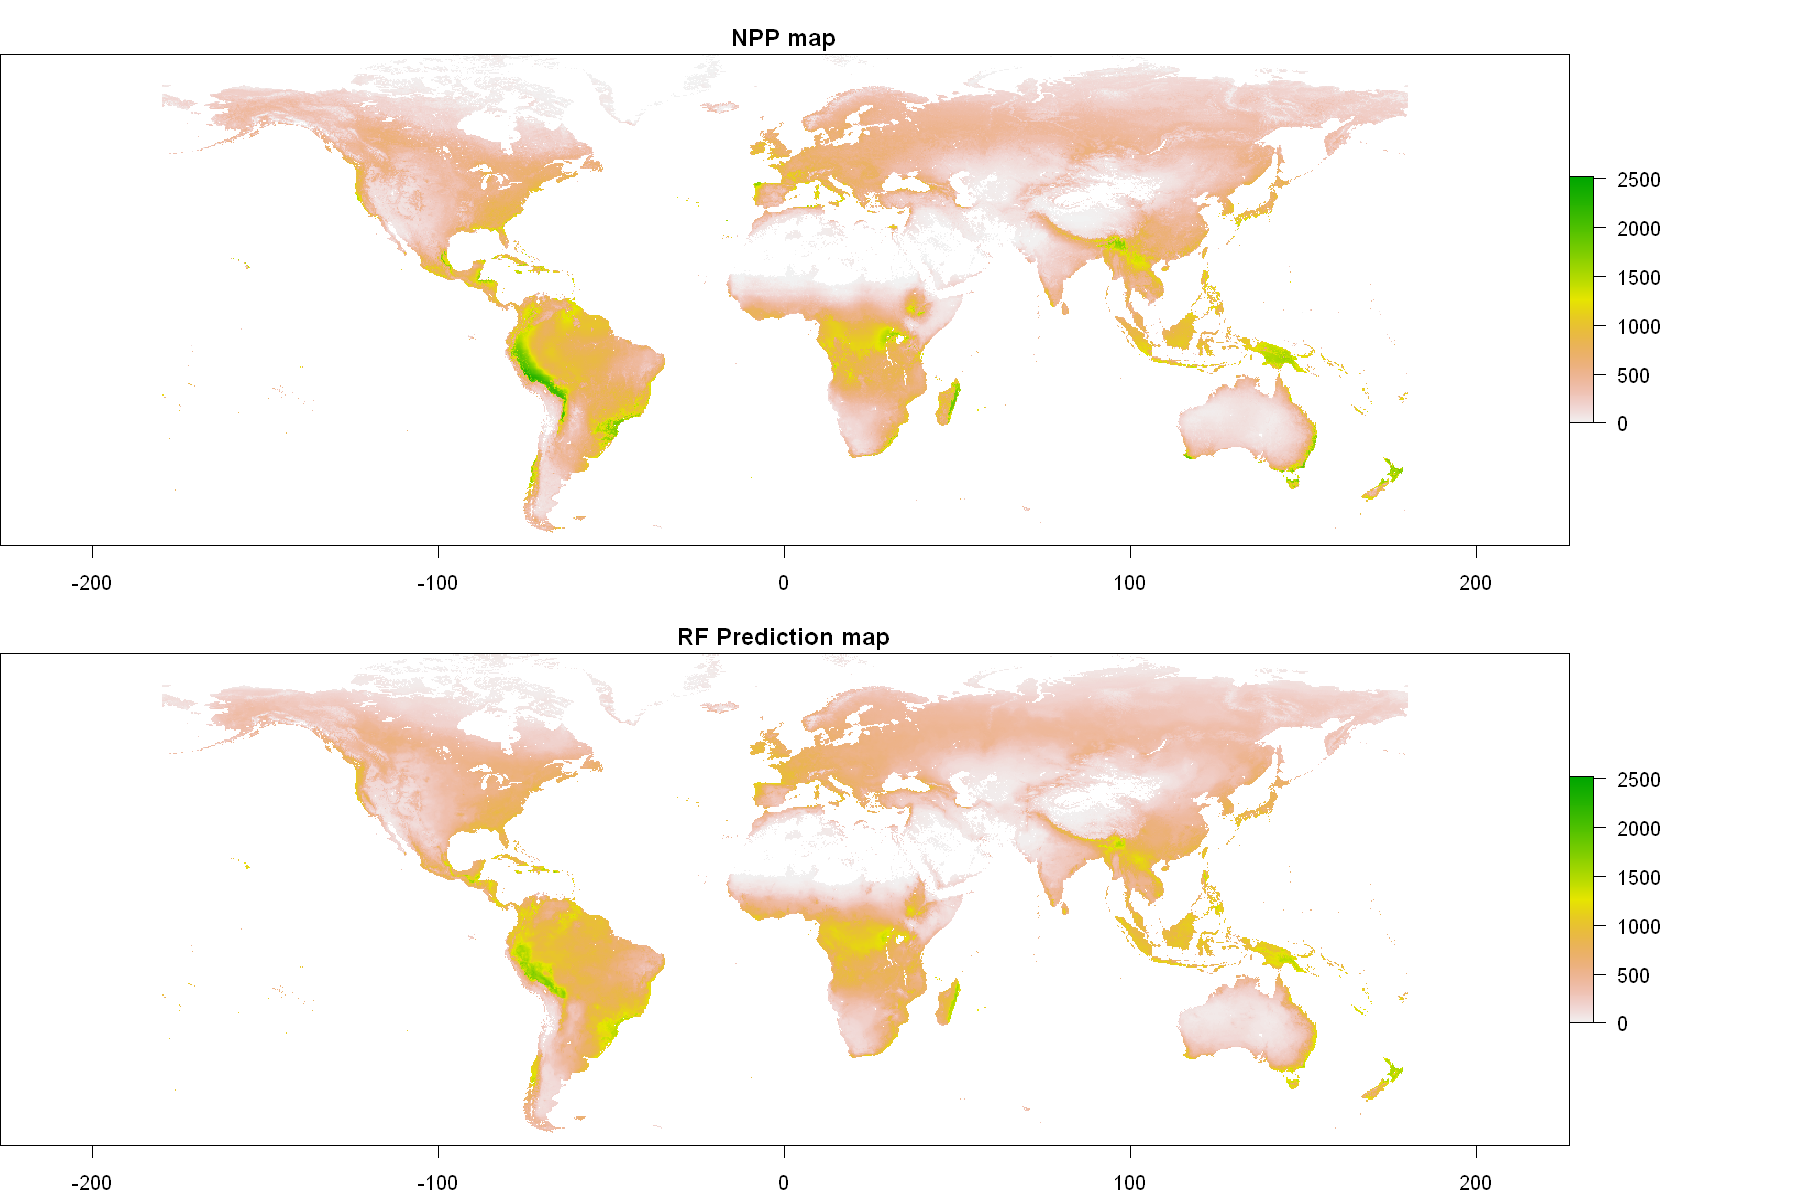

In [29]:
options(repr.plot.width = 15, repr.plot.height = 10)
par(mfrow=c(2,1), mar=c(1.5,0,1.5,0))
plot(clean_npp, main="NPP map", zlim=c(0,2520))
plot(RF_prediction, main="RF Prediction map", zlim=c(0,2520))
par(mfrow=c(1,1))

**THAT LOOKS GOOD!**

Explore the errors

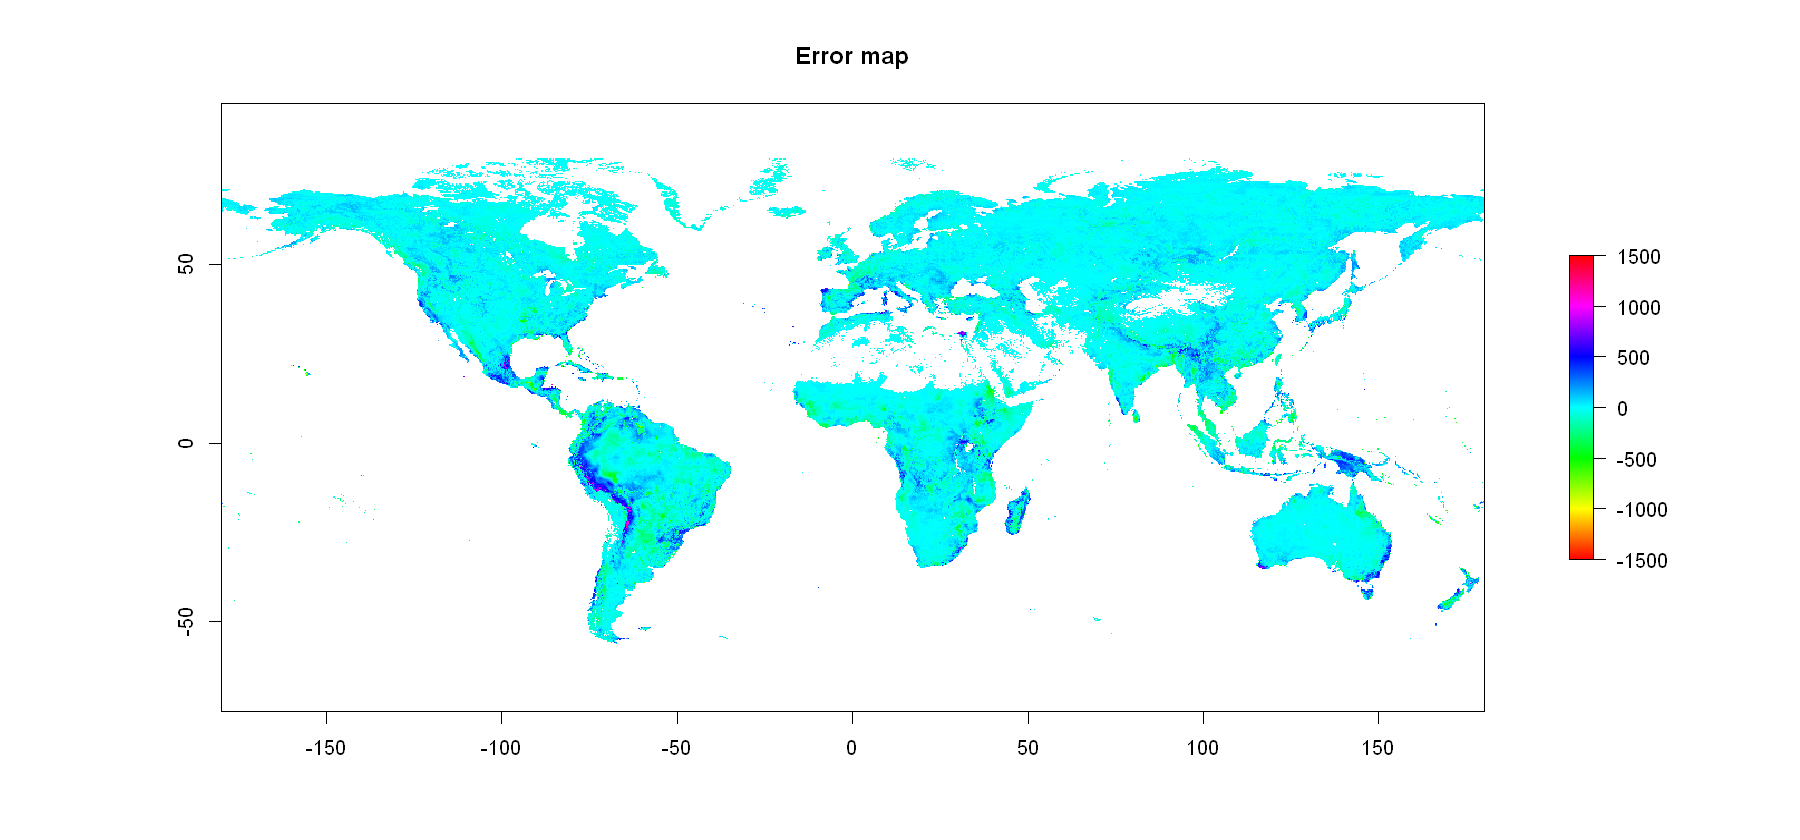

In [34]:
RF_error_map <- (clean_npp - RF_prediction)
options(repr.plot.width = 15, repr.plot.height = 7)
plot(RF_error_map, main="Error map", col=rainbow(2500), zlim=c(-1500, 1500))

High productivity areas seem to be the most problematic for the model, but overall the fit is very good!

### KNN prediction

Transform map layers according to transformation of the variables in the model (min-max)

In [35]:
normalize_minmax <- function(x)
{
  return((x- min(x)) /(max(x)-min(x)))
}

all_bio_norm <- calc(all_bio, normalize_minmax)
names(all_bio_norm) <- names(all_bio)

Predict the model into map, and do reverse transformation of the results ( _exp()_ )

In [36]:
beginCluster()
KNN_prediction <- raster::predict(all_bio_norm, reg_KNN_norm)
KNN_prediction <- exp(KNN_prediction)
endCluster()

12 cores detected, using 11



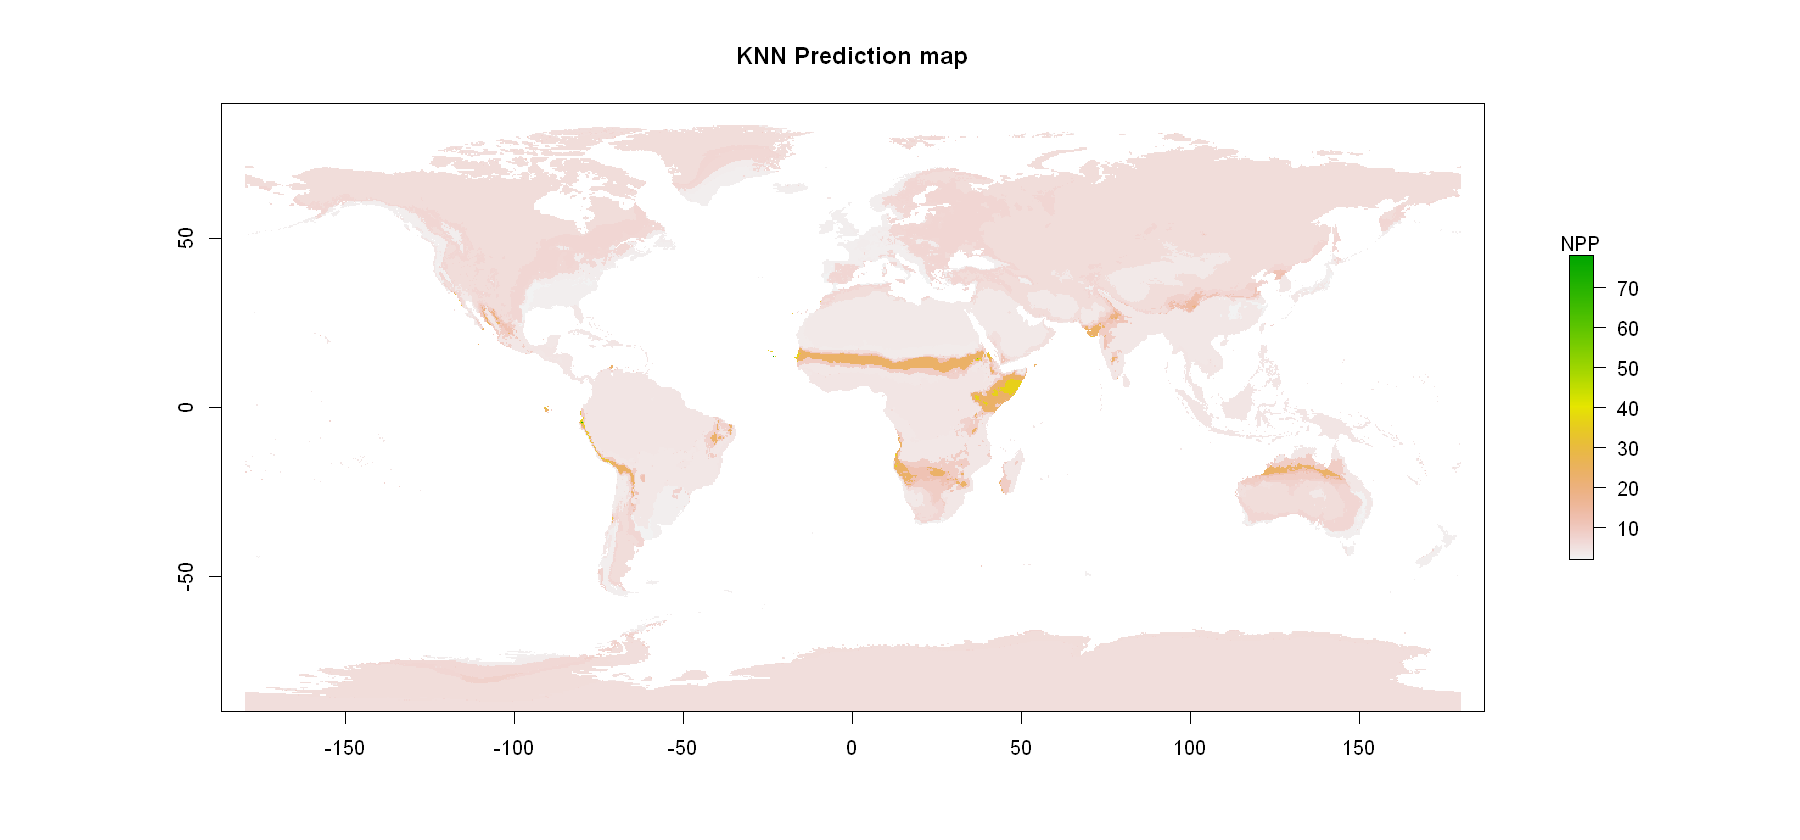

In [38]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot(KNN_prediction, main="KNN Prediction map",legend.args = list(text = 'NPP'))

Ok... something is wrong here. I still have it in my to-do list to try and figure out what is going wrong (likely in the reverse transformation).  
  
    
**Random forest will remain as the preferred method**